In [19]:
import os
import time
from collections import OrderedDict
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.transforms.functional import to_tensor
from torchmetrics import BLEUScore

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split

import wandb


# set WANDB_NOTEBOOK_NAME 
os.environ['WANDB_NOTEBOOK_NAME'] = 'mc2.ipynb'


# Config

In [111]:
config = dict(
    epochs=150,
    batch_size=128,
    learning_rate=0.001,
    accelerator='gpu' if torch.cuda.is_available() else None,
    image_dir = 'flickr8k/images',
    caption_file = 'flickr8k/captions.txt',
    embedding_dim = 512,
    hidden_dim = 512,
    lstm_layers = 3,
    max_caption_length = 40,
    seed = 42,
    debug = False,
)

config

{'epochs': 150,
 'batch_size': 128,
 'learning_rate': 0.001,
 'accelerator': 'gpu',
 'image_dir': 'flickr8k/images',
 'caption_file': 'flickr8k/captions.txt',
 'embedding_dim': 512,
 'hidden_dim': 512,
 'lstm_layers': 3,
 'max_caption_length': 40,
 'seed': 42,
 'debug': False}

# Vocab

In [3]:
class Vocab():

    def __init__(self, captions_file, tokenizer):
        self.tokenizer = tokenizer
        self.captions_file = captions_file
        self.build_vocab()

    def build_vocab(self):
        vocab = OrderedDict()

        # Add special tokens
        vocab['<pad>'] = None
        vocab['<sos>'] = None
        vocab['<eos>'] = None
        vocab['<unk>'] = None

        captions = pd.read_csv(config["caption_file"], delimiter='|')['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', ' ', regex=True)
        if config["debug"]:
            captions = captions[:500:5]
        
        token_freq = {}
        for caption in captions:
            for token in self.tokenizer(caption):
                if token not in token_freq:
                    token_freq[token] = 1
                else:
                    token_freq[token] += 1

        for token, freq in token_freq.items():
            if freq >= 3:
                vocab[token] = None


        self.idx2word = list(vocab.keys())
        self.word2idx = {word: idx for idx, word in enumerate(self.idx2word)}

        self.pad_idx = self.word2idx['<pad>']
        self.sos_idx = self.word2idx['<sos>']
        self.eos_idx = self.word2idx['<eos>']

    def __len__(self):
        return len(self.idx2word)

    def token_to_idx(self, token):
        if token not in self.word2idx:
            return self.word2idx['<unk>']
        else:
            return self.word2idx[token]

    def idx_to_token(self, idx):
        return self.idx2word[idx]


special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture <word> tokens

vocab = Vocab(config["caption_file"], tokenizer=special_word_tokenizer.tokenize)

print(f'Vocab size: {len(vocab)}, Pad index: {vocab.pad_idx}, SOS index: {vocab.sos_idx}, EOS index: {vocab.eos_idx}')

Vocab size: 4097, Pad index: 0, SOS index: 1, EOS index: 2


In [4]:
# debug vocab
test_string = 'a brown dog is running on the grass, like florin!'
print(f'Original string: {test_string}')
tokenized_string = special_word_tokenizer.tokenize(test_string)
print(f'Tokenized string: {tokenized_string}')
tokenized_string_idx = [vocab.token_to_idx(token) for token in tokenized_string]
print(f'Tokenized string indices: {tokenized_string_idx}')
converted_string = [vocab.idx_to_token(idx) for idx in tokenized_string_idx]
print(f'Converted string: {converted_string}')

Original string: a brown dog is running on the grass, like florin!
Tokenized string: ['a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', 'like', 'florin']
Tokenized string indices: [4, 42, 29, 9, 114, 39, 24, 66, 1160, 3]
Converted string: ['a', 'brown', 'dog', 'is', 'running', 'on', 'the', 'grass', 'like', '<unk>']


# Dataset

In [84]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, image_ids, tokenizer, vocab, transform=None, group_by_image=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): Path to the txt file with captions.
            transform (callable, optional): Optional transform to be applied
                on a image sample.
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file, delimiter='|')
        if image_ids is not None:
            self.df = self.df[self.df['image_name'].isin(image_ids)]
        if config["debug"]:
            # select only the first 10 images for testing
            self.df = self.df[:100:1]
        self.transform = transform
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.group_by_image = group_by_image

        # clean caption_text
        self.df['caption_text'] = self.df['caption_text'].str.lower() \
                                                         .replace(r"[^a-zA-Z0-9\s]+", "", regex=True) \
                                                         .replace(r'\s+', " ", regex=True)
        # append <start> and <end> to caption_text
        self.df['caption_text'] = self.df['caption_text'].apply(lambda x: '<sos> ' + x + ' <eos>') \
                                                         .apply(lambda x: torch.LongTensor(self._caption_to_idx(x)))
        # store memory
        self.captions_image_names = list(zip(self.df['caption_text'], self.df['image_name']))
        
        self.images = {}

        # load all images into memory
        for img_name in tqdm(self.df['image_name'].unique()):
            img_path = os.path.join(self.root_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)

            self.images[img_name] = image

    def _caption_to_idx(self, caption):
        return [self.vocab.token_to_idx(word) for word in self.tokenizer(caption)]
    
    def __len__(self):
        if self.group_by_image:
            return len(self.images)
        else:
            return len(self.df)

    def __getitem__(self, idx):
        if self.group_by_image:
            img_name = list(self.images.keys())[idx]
            image = self.images[img_name]
            captions = self.df[self.df['image_name'] == img_name]['caption_text'].tolist()
            #captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.vocab.pad_idx)
            return image, captions
        else:
            caption, img_name = self.captions_image_names[idx]
            image = self.images[img_name]
            return image, caption

In [87]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        images, captions = zip(*batch)
        images = torch.stack(images)
        if isinstance(captions[0], list):
            captions = [torch.nn.utils.rnn.pad_sequence(caption, batch_first=True, padding_value=self.pad_idx) for caption in captions]
        else:
            captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions

In [97]:
group_by_image = True
dataset = Flickr8kDataset(config["image_dir"],
                          config["caption_file"],
                            None,
                          special_word_tokenizer.tokenize,
                          vocab,
                          models.ResNet50_Weights.IMAGENET1K_V1.transforms(),
                          group_by_image=group_by_image)
(dataset[0][0].shape, dataset[0][1])

test_loader = DataLoader(dataset,
                         batch_size=config["batch_size"],
                         shuffle=False,
                         pin_memory=True,
                         collate_fn=Collate(vocab.pad_idx))# if not group_by_image else None)
len(next(iter(test_loader))[1][0])
next(iter(test_loader))[0].size(), len(next(iter(test_loader))[1]), next(iter(test_loader))[1][0].size()

100%|██████████| 20/20 [00:00<00:00, 120.03it/s]


(torch.Size([20, 3, 224, 224]), 20, torch.Size([5, 19]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


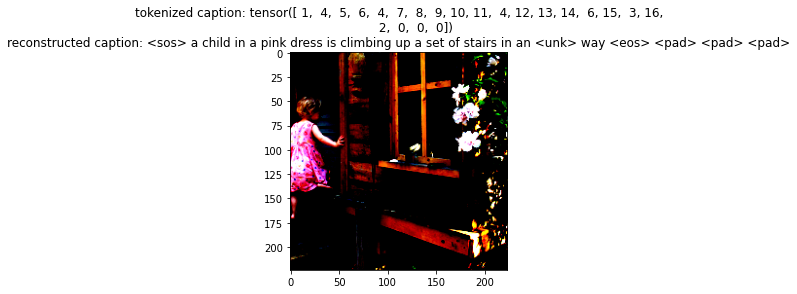

In [62]:
test_loader = DataLoader(dataset,
                         batch_size=config["batch_size"],
                         shuffle=False,
                         pin_memory=True,
                         collate_fn=Collate(vocab.pad_idx))
for i, (images, captions) in enumerate(test_loader):
    token_caption = captions[0]
    reconstructed_caption = [vocab.idx_to_token(idx) for idx in token_caption]
    plt.imshow(images[0].permute(1, 2, 0))
    plt.title(f"tokenized caption: {token_caption}\nreconstructed caption: {' '.join(reconstructed_caption)}")
    plt.show()
    break

In [9]:
# analyze the captions lengths
lengths = []
total_data_loader_len = len(test_loader)
for i, (images, captions) in tqdm(enumerate(test_loader), total=total_data_loader_len):
    lengths.append(np.array(captions.shape[1] - (captions == vocab.pad_idx).sum(dim=1)))

100%|██████████| 317/317 [00:10<00:00, 29.31it/s]


In [10]:
# convert lengths to numpy array
np.concatenate(lengths).shape

(40455,)

Captions lengths shape: (40455,)


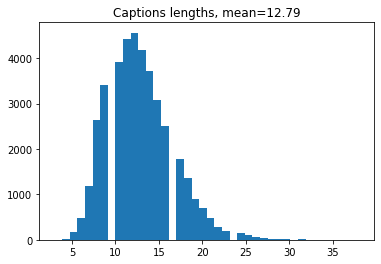

In [11]:
lengths_arr = np.concatenate(lengths)

print("Captions lengths shape:", lengths_arr.shape)

plt.hist(lengths_arr, bins=40)
plt.title("Captions lengths, mean={:.2f}".format(lengths_arr.mean()))
plt.show()


# Model

In [101]:

class ImageCaptioning(pl.LightningModule):

    def __init__(self, embedding_dim: int, lstm_layers: int, hidden_dim: int, vocabulary_size: int, padding_idx: int, learning_rate: float):
        super(ImageCaptioning, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Sequential(*list(models.resnet50(weights=models.ResNet50_Weights.DEFAULT).children())[:-1]),
            nn.Flatten(),
            nn.Linear(models.resnet50().fc.in_features, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        for param in self.encoder[0].parameters():
            param.requires_grad_(False)

        # Decoder
        self.decoder = nn.ModuleDict({
            'embedding_layer': nn.Embedding(vocabulary_size, embedding_dim),
            'lstm': nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=lstm_layers, dropout = 0.5),
            'inv_embedding': nn.Sequential(nn.Linear(hidden_dim, vocabulary_size), nn.LogSoftmax(dim=2))
        })
        
        self.learning_rate = learning_rate

        self.bleu_score = BLEUScore(smooth=True)

        self.save_hyperparameters()


    def forward(self, images: torch.Tensor, captions: torch.Tensor) -> torch.Tensor:
        # Encoder forward
        # images: (batch_size, channels, pixels, pixels)
        image_embedding = self.encoder(images) # (batch_size, embedding_dim)

        # Decoder forward
        word_embeddings = self.decoder['embedding_layer'](captions).permute(1, 0, 2) # (seq_len, batch_size, embedding_dim)
        
        embeddings = torch.cat((image_embedding.unsqueeze(0), word_embeddings), dim=0)

        outputs, _ = self.decoder['lstm'](embeddings) # (seq_len, batch_size, embedding_dim)
        outputs = self.decoder['inv_embedding'](outputs) # (seq_len, batch_size, vocab_size)
        return outputs


    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.learning_rate, weight_decay=0.0001)

    
    def training_step(self, batch, batch_idx):
        self.train()
        # TODO dedupe code
        images, captions = batch
        outputs = self(images, captions[:,:-1])
        outputs = outputs[1:].reshape(-1, outputs.size(2)) # remove the first word from the output
        captions = captions.permute(1, 0)[1:].reshape(-1) # remove the first word from the target
        loss = F.nll_loss(outputs, captions, ignore_index=int(vocab.pad_idx))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        self.eval()
        images, captions = batch
        outputs = self(images, captions[:,:-1])
        outputs = outputs[1:].reshape(-1, outputs.size(2)) # remove the first word from the output
        captions = captions.permute(1, 0)[1:].reshape(-1) # remove the first word from the target
        loss = F.nll_loss(outputs, captions, ignore_index=int(vocab.pad_idx))
        self.log('val_loss', loss)
        return loss
    

    def test_step(self, batch, batch_idx):
        """
        Compute the BLEU score for the generated captions

        Args:
            batch: (images, target_caption_groups)
                images: (batch_size, channels, pixels, pixels)
                target_caption_groups: list of (5, seq_len) tensors
        """
        self.eval()
        images, target_caption_groups = batch # captions contain all the 5 possible captions for each image
        outputs_gredy = self.sample_greedy(images, max_length=config["max_caption_length"])
        outputs_beam = self.sample_beam(images, max_length=config["max_caption_length"])

        generated_sentences_greedy = [" ".join([vocab.idx_to_token(idx) for idx in caption]) for caption in outputs_gredy]
        generated_sentences_beam = [" ".join([vocab.idx_to_token(idx) for idx in caption]) for caption in outputs_beam]

        target_sentence_groups = [[" ".join([vocab.idx_to_token(idx) for idx in caption]) for caption in target_caption_group] for target_caption_group in target_caption_groups]
        self.log_dict({
            'bleu_score_greedy': self.bleu_score(generated_sentences_greedy, target_sentence_groups),
            'bleu_score_beam': self.bleu_score(generated_sentences_beam, target_sentence_groups)
        })

    def sample_greedy(self, images: torch.Tensor, max_length: int = 30):
        self.eval()
        image_embeddings = self.encoder(images).unsqueeze(0) # (1, batch_size, embedding_dim)
        input_tokens = torch.tensor([[vocab.sos_idx]], device=images.device).repeat(1, images.size(0)) # (1, batch_size)

        output, hidden = self.decoder['lstm'](image_embeddings)

        generated_captions = []
        for _ in range(max_length):
            # Embed the input
            input_embeddings = self.decoder['embedding_layer'](input_tokens)
            
            # LSTM forward
            outputs, hidden = self.decoder['lstm'](input_embeddings, hidden)
            outputs = self.decoder['inv_embedding'](outputs)
            
            # Get the maximum probable words (greedy decoding)
            predicted_word_idx = outputs.argmax(dim=2)
            generated_captions.append(predicted_word_idx)

            input_tokens = predicted_word_idx # (1, batch_size)

        return torch.cat(generated_captions, dim=0).permute(1, 0).tolist() # (batch_size, max_length)

    def sample_beam(self, images: torch.Tensor, max_length: int = 30, beam_size: int = 5):
        self.eval()
        image_embeddings = self.encoder(images).unsqueeze(0) # (1, batch_size, embedding_dim)
        input_tokens = torch.tensor([[vocab.sos_idx]], device=images.device).repeat(1, images.size(0)) # (1, batch_size)

        output, hidden = self.decoder['lstm'](image_embeddings)

        generated_captions = []



image_captioning = ImageCaptioning(512, 1, 1024, len(vocab), vocab.pad_idx, 0.001).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 

image_captioning.train()

# create random tensor of images and captions 
images = torch.randn(32, 3, 500, 500).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 
# sequence of 40 words
captions = torch.randint(0, len(vocab), (32, 40)).to(torch.device('cuda')) # just to get feedback faster, not used in pl.Trainer 
print("captions:", captions.size())

outputs = image_captioning(images, captions[:,:-1])


print("outputs:", outputs.size())

# compute loss
#loss = nn.NLLLoss()(outputs.permute(1, 2, 0), captions.permute(1, 0))
loss = nn.NLLLoss(ignore_index=int(vocab.pad_idx))(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))

print("loss:", loss)

# check if on cuda
print(next(image_captioning.parameters()).is_cuda)
print(next(image_captioning.encoder.parameters()).is_cuda)
print(next(image_captioning.decoder['embedding_layer'].parameters()).is_cuda)
print(next(image_captioning.decoder['lstm'].parameters()).is_cuda)
print(next(image_captioning.decoder['inv_embedding'].parameters()).is_cuda)
print(outputs.is_cuda)

# convert outputs to captions_idx
captions = torch.argmax(outputs, dim=2)
print("captions:", captions.size())

# convert captions_idx to captions
captions = [[vocab.idx_to_token(idx.item()) for idx in caption] for caption in captions]
print("captions:", captions[0])

# 5 images
image = torch.randn(5, 3, 500, 500).to(torch.device('cuda')) 
caption = image_captioning.sample_greedy(image)
print("Generated caption:", caption)
caption_sentence = [vocab.idx_to_token(idx) for idx in caption[0]]
target_sentences = [" ".join(caption) for caption in captions]
bleu_score = image_captioning.bleu_score(caption_sentence, target_sentences)
print("BLEU score:", bleu_score)

c:\Users\flori\miniconda3\envs\del\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


captions: torch.Size([32, 40])
outputs: torch.Size([40, 32, 4097])
loss: tensor(8.3204, device='cuda:0', grad_fn=<NllLossBackward0>)
True
True
True
True
True
True
captions: torch.Size([40, 32])
captions: ['sandbox', 'dumbbell', 'begging', 'telescope', 'participates', 'highway', 'rider', 'sloping', 'pitcher', 'crossing', 'moves', 'carried', 'go', 'skiers', 'frog', 'marathon', 'golf', 'boots', 'suspenders', 'clown', 'worn', 'peaking', 'rottweiler', 'riverbank', 'onlookers', 'mounds', 'pitbull', 'had', 'shepherd', 'float', 'card', 'clause']
Generated caption: [[1387, 688, 749, 3910, 3918, 4046, 1241, 2001, 1893, 2539, 868, 2707, 106, 2828, 750, 2356, 15, 1995, 1520, 1520, 2060, 4087, 2597, 2114, 1038, 145, 377, 3816, 1708, 943], [1387, 688, 749, 3910, 3918, 4046, 1241, 2001, 1893, 2539, 868, 2707, 106, 2828, 750, 2356, 15, 1995, 1520, 1520, 2060, 4087, 2597, 2114, 1038, 145, 377, 3816, 1708, 943], [1387, 688, 749, 3910, 3918, 4046, 1241, 2001, 1893, 2539, 868, 2707, 106, 2828, 750, 2356, 

In [13]:
image_captioning

ImageCaptioning(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
     

In [15]:
"""
# visualize the model
from torchviz import make_dot

# print number of parameters
params = list(image_encoder.parameters()) + list(caption_decoder.parameters())
print("Number of parameters:", sum([np.prod(p.size()) for p in params]))

make_dot(outputs, params=dict(list(image_encoder.named_parameters()) + list(caption_decoder.named_parameters()))).render("model", format="png")
"""

'\n# visualize the model\nfrom torchviz import make_dot\n\n# print number of parameters\nparams = list(image_encoder.parameters()) + list(caption_decoder.parameters())\nprint("Number of parameters:", sum([np.prod(p.size()) for p in params]))\n\nmake_dot(outputs, params=dict(list(image_encoder.named_parameters()) + list(caption_decoder.named_parameters()))).render("model", format="png")\n'

# Data Module

In [104]:
class Flickr8kDataModule(pl.LightningDataModule):
    def __init__(self, config, transform=None):
        super().__init__()
        self.config = config
        self.transform = transform
        self.special_word_tokenizer = RegexpTokenizer( r'(?:\w+|<\w+>)') # capture <word> tokens
        self.vocab = Vocab(self.config["caption_file"], tokenizer=self.special_word_tokenizer.tokenize)
        self.config['vocab_size'] = len(self.vocab)
        self.collate_fn = Collate(self.vocab.pad_idx)


    def setup(self, stage=None):
        # check if train_dataset variable exists
        if hasattr(self, 'train_dataset'):
            return
        # read the dataframe and make split on images
        df = pd.read_csv(self.config["caption_file"], delimiter='|')
        image_ids = df['image_name'].unique()

        train_image_ids, test_image_ids = train_test_split(image_ids, test_size=0.2, random_state=self.config["seed"]) # 80% train
        val_image_ids, test_image_ids = train_test_split(test_image_ids, test_size=0.5, random_state=self.config["seed"]) # 10% val, 10% test

        # create datasets
        self.train_dataset = Flickr8kDataset(self.config["image_dir"],
                                        self.config["caption_file"],
                                        train_image_ids,
                                        self.special_word_tokenizer.tokenize,
                                        self.vocab,
                                        self.transform)
        self.val_dataset = Flickr8kDataset(self.config["image_dir"],
                                        self.config["caption_file"],
                                        val_image_ids,
                                        self.special_word_tokenizer.tokenize,
                                        self.vocab,
                                        self.transform)
        self.test_dataset = Flickr8kDataset(self.config["image_dir"],
                                        self.config["caption_file"],
                                        test_image_ids,
                                        self.special_word_tokenizer.tokenize,
                                        self.vocab,
                                        self.transform,
                                        group_by_image=True)

    def dataloader(self, dataset, shuffle=False, collate=True):
        return DataLoader(dataset,
                          batch_size=self.config["batch_size"],
                          shuffle=shuffle,
                          pin_memory=True,
                          collate_fn=Collate(self.vocab.pad_idx))


    def train_dataloader(self): return self.dataloader(self.train_dataset, shuffle=True)
    def val_dataloader  (self): return self.dataloader(self.val_dataset)
    def test_dataloader (self): return self.dataloader(self.test_dataset, collate=False)

flickr8k_data_module = Flickr8kDataModule(config, transform=models.ResNet50_Weights.IMAGENET1K_V1.transforms())

In [105]:
flickr8k_data_module.setup()

100%|██████████| 810/810 [00:07<00:00, 104.65it/s]


In [100]:
image, sentences = next(iter(flickr8k_data_module.train_dataloader()))
print(f"Train loader image shape: {image.shape}, sentences shape: {sentences.shape}")
test = next(iter(flickr8k_data_module.test_dataloader()))
len(test)

Train loader image shape: torch.Size([100, 3, 224, 224]), sentences shape: torch.Size([100, 22])


2

# Training

In [107]:
wandb.finish()

bleu_score,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
train_loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▃▂▃▃▂▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇████
val_loss,▁
bleu_score,0.01838
epoch,1
train_loss,4.15162
trainer/global_step,253
val_loss,4.06301


In [108]:
# Use the DataModule with a PyTorch Lightning Trainer
wandb_logger = WandbLogger(project="del-mc2", entity="florin-barbisch", config=config, log_model="all")

model = ImageCaptioning(
    config["embedding_dim"],
    config["lstm_layers"],
    config["hidden_dim"],
    len(flickr8k_data_module.vocab),
    flickr8k_data_module.vocab.pad_idx,
    config["learning_rate"]
)

wandb_logger.watch(model, log="all")

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss')
early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5)

trainer = pl.Trainer(
    accelerator = config["accelerator"],
    max_epochs = 1,#config["epochs"],
    callbacks = [checkpoint_callback, early_stopping_callback],
    logger = wandb_logger,
    log_every_n_steps = 10
)

trainer.fit(model, flickr8k_data_module)
trainer.test(model, flickr8k_data_module.test_dataloader())
wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 24.6 M
1 | decoder    | ModuleDict | 10.5 M
2 | bleu_score | BLEUScore  | 0     
------------------------------------------
11.6 M    Trainable params
23.5 M    Non-trainable params
35.1 M    Total params
140.245   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\flori\miniconda3\envs\del\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       bleu_score           0.02405157871544361
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


bleu_score,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
train_loss,█▇▆▆▇▆▆▆▆▅▅▅▅▄▄▃▃▃▂▂▁▂▂▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇████
val_loss,▁
bleu_score,0.02405
epoch,1
train_loss,4.18159
trainer/global_step,253
val_loss,4.05654


In [110]:
artifact_dir = wandb.Api().artifact(f"florin-barbisch/del-mc2/model-1lurxa3y:best_k").download()
model = ImageCaptioning.load_from_checkpoint(os.path.join(artifact_dir, "model.ckpt"))

wandb: Downloading large artifact model-1lurxa3y:best_k, 222.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


In [ ]:
# load model from "Run data is saved locally in .\wandb\run-20230608_075712-xf91x694"
#model = ImageCaptioning.load_from_checkpoint("wandb/run-20230608_075712-xf91x694/files/epoch=0-step=0.ckpt")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'group', 'of', 'men', 'in', 'red', 'shirts', 'and', 'black', 'pants', 'are', 'dancing', 'in', 'front', 'of', 'a', 'crowd', '<eos>']]


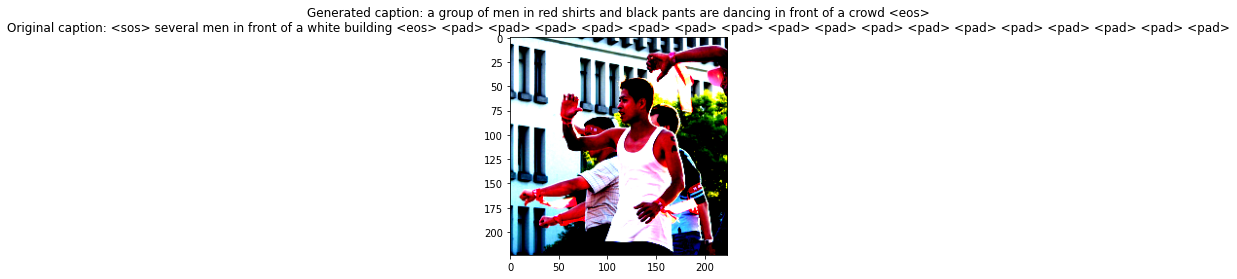

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'woman', 'with', 'a', 'red', 'shirt', 'and', 'a', 'woman', 'with', 'a', 'pink', 'shirt', '<eos>']]


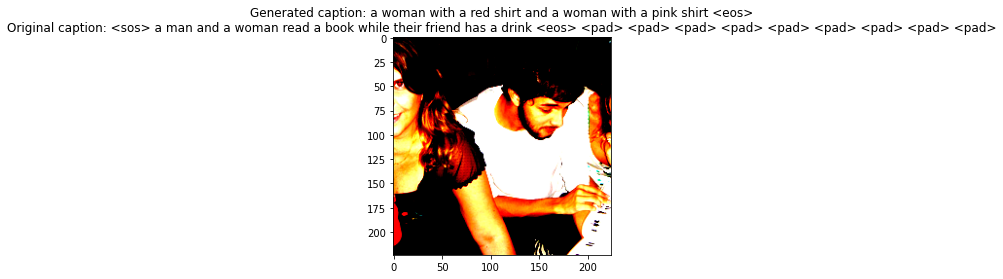

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'woman', 'in', 'a', 'black', 'jacket', 'and', 'sunglasses', 'is', 'smiling', '<eos>']]


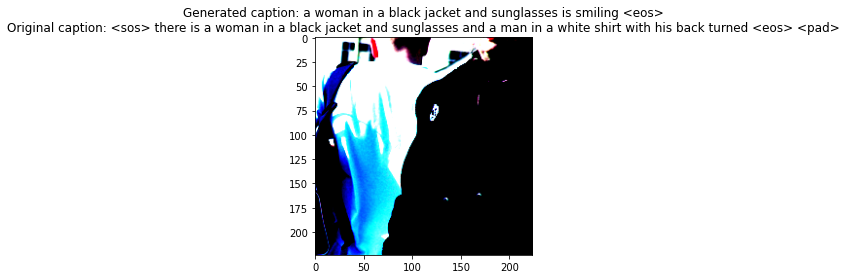

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'brown', 'dog', 'runs', 'through', 'the', 'grass', '<eos>']]


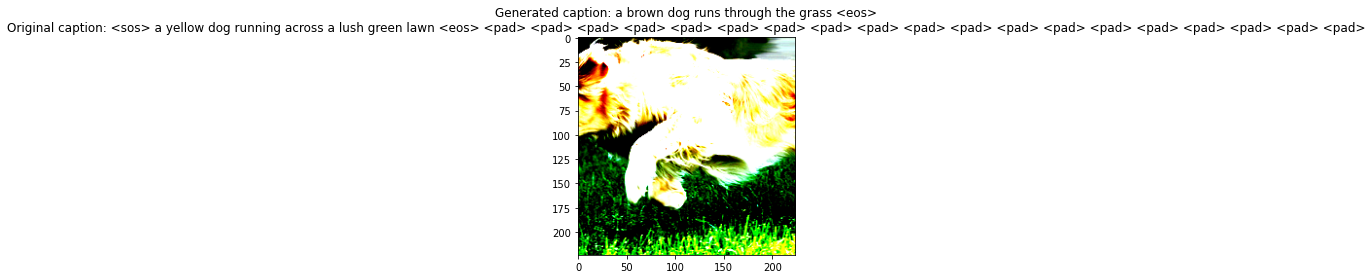

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated caption: [['a', 'dog', 'is', 'running', 'through', 'a', 'field', '<eos>']]


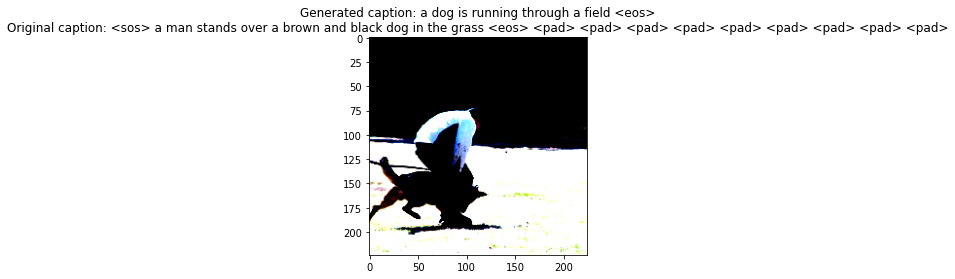

In [20]:
# sample on first image and show the result
model = model.to(torch.device('cuda'))

i = 0
for image, caption in iter(flickr8k_data_module.train_dataloader()):
    if i == 5:
        break
    i += 1
    image = image.to(torch.device('cuda'))
    image = image[0].unsqueeze(0)
    # send image to cuda
    #caption = caption[0].unsqueeze(0)

    generated_caption = model.sample_greedy(image)
    print("Generated caption:", generated_caption)

    plt.imshow(image[0].permute(1, 2, 0).cpu())
    plt.title(f"Generated caption: {' '.join(generated_caption[0])}\nOriginal caption: {' '.join([flickr8k_data_module.vocab.idx_to_token(idx.item()) for idx in caption[0]])}")
    plt.show()